# Most Important Notebook probably

In [1]:
from bci_aic3.config import load_processing_config
from bci_aic3.data import load_raw_data
from bci_aic3.paths import (
    LABEL_MAPPING_PATH,
    MI_CONFIG_PATH,
    RAW_DATA_DIR,
    SSVEP_CONFIG_PATH,
)

# from bci_aic3.preprocess import preprocessing_pipeline
from bci_aic3.util import read_json_to_dict

In [2]:
task_type = "MI"
config_path = MI_CONFIG_PATH

processing_config = load_processing_config(config_path)
label_mapping = read_json_to_dict(LABEL_MAPPING_PATH)

In [3]:

train, val, _ = load_raw_data(
    base_path=RAW_DATA_DIR,
    task_type=task_type,
    label_mapping=label_mapping,
)

100%|██████████| 50/50 [00:02<00:00, 21.57it/s]


In [4]:
import matplotlib.pyplot as plt

In [ ]:
import mne
import numpy as np
from scipy.signal import butter, filtfilt
import torch
from torch.utils.data import DataLoader
from torcheeg import transforms
from torcheeg.transforms import Lambda, BaseTransform

from bci_aic3.config import ProcessingConfig
from bci_aic3.data import BCIDataset
from bci_aic3.paths import (
    PROCESSED_DATA_DIR,
    TRAINING_STATS_PATH,
)


class MNENotchFilter:
    """A callable transform class to apply a notch filter using MNE."""

    def __init__(self, config):
        self.sfreq = config.sfreq
        self.notch_freq = config.notch_freq

    def __call__(self, **kwargs):
        """Apply the notch filter to the EEG data."""
        eeg = kwargs["eeg"]

        # Convert to numpy if torch tensor
        if isinstance(eeg, torch.Tensor):
            device = eeg.device
            dtype = eeg.dtype
            eeg_np = eeg.detach().cpu().numpy()
            was_torch = True
        else:
            eeg_np = eeg
            was_torch = False

        eeg_np = eeg_np.astype(float)
        filtered = mne.filter.notch_filter(
            eeg_np,
            Fs=self.sfreq,
            freqs=self.notch_freq,
            method="iir",
            verbose=False,
        )

        # Convert back to torch if input was torch
        if was_torch:
            kwargs["eeg"] = torch.from_numpy(filtered).to(device=device, dtype=dtype)
        else:
            kwargs["eeg"] = filtered

        return kwargs


class BandPassFilter:
    """Simple bandpass filter for EEG signals."""

    def __init__(self, config):
        self.sfreq = config.sfreq
        self.lfreq = config.bandpass_low
        self.hfreq = config.bandpass_high
        self.order = config.filter_order

        # Pre-compute filter coefficients
        nyquist = self.sfreq / 2
        low = self.lfreq / nyquist
        high = self.hfreq / nyquist
        self.b, self.a = butter(self.order, [low, high], btype="bandpass")  # type: ignore

    def __call__(self, **kwargs):
        """Apply bandpass filter to EEG data."""
        eeg = kwargs["eeg"]

        # Convert to torch if numpy
        if isinstance(eeg, np.ndarray):
            eeg = torch.from_numpy(eeg).float()
            was_numpy = True
        else:
            was_numpy = False

        device = eeg.device
        dtype = eeg.dtype

        # Convert to numpy and filter
        eeg_np = eeg.detach().cpu().numpy()

        if eeg_np.ndim == 2:
            filtered = np.array([filtfilt(self.b, self.a, ch) for ch in eeg_np])
        else:  # 3D
            filtered = np.array(
                [[filtfilt(self.b, self.a, ch) for ch in batch] for batch in eeg_np]
            )

        kwargs["eeg"] = torch.from_numpy(filtered).to(device=device, dtype=dtype)
        return kwargs


class CustomCrop:
    """A callable transform class to crop the EEG signal in time."""

    def __init__(self, start: int, end: int):
        self.start = start
        self.end = end

    def __call__(self, **kwargs):
        """Apply temporal cropping to the EEG data."""
        eeg = kwargs["eeg"]

        if isinstance(eeg, torch.Tensor):
            kwargs["eeg"] = eeg[:, self.start : self.end]
        else:
            kwargs["eeg"] = eeg[:, self.start : self.end]

        return kwargs

class FixedMeanStdNormalize(BaseTransform):
    """
    Normalize EEG data using precomputed mean and std per channel.
    
    Args:
        mean: Tensor of shape (n_channels,) with mean per channel.
        std: Tensor of shape (n_channels,) with std per channel.
    """
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean
        self.std = std

    def __call__(self, **kwargs):
        """
        Apply normalization to a single EEG sample.
        
        Args:
            data: Tensor of shape (n_channels, n_timepoints).
        
        Returns:
            Normalized tensor of the same shape.
        """
        eeg = kwargs["eeg"]
        
        if isinstance(eeg, torch.Tensor):
            kwargs["eeg"] = (eeg - self.mean[:, None]) / self.std[:, None]
        else:
            kwargs["eeg"] = (eeg - self.mean[:, None]) / self.std[:, None]
        return kwargs


def preprocessing_pipeline(
    train_dataset: BCIDataset,
    validation_dataset: BCIDataset,
    task_type: str,
    processing_config: ProcessingConfig,
):
    """
    The main pipeline to preprocess data using a torcheeg-based approach.

    This pipeline:
    1. Defines a series of transforms (Notch, Bandpass, Crop, Normalize).
    2. Applies initial transforms to the training data to calculate normalization stats.
    3. Creates a full pipeline with the calculated stats.
    4. Applies the full pipeline to both training and validation data.
    5. Saves the processed data to disk.
    """
    # Load all data into memory from the datasets
    train_loader = DataLoader(
        train_dataset, batch_size=len(train_dataset), shuffle=False
    )
    train_data, train_labels = next(iter(train_loader))
    train_data, train_labels = train_data.numpy(), train_labels.numpy()

    val_loader = DataLoader(
        validation_dataset, batch_size=len(validation_dataset), shuffle=False
    )
    val_data, val_labels = next(iter(val_loader))
    val_data, val_labels = val_data.numpy(), val_labels.numpy()

    # --- Step 1: Define initial transforms (before normalization) ---
    start_idx = int(processing_config.tmin * processing_config.sfreq)
    end_idx = int(processing_config.tmax * processing_config.sfreq)


    initial_transforms = None
    if task_type.upper() == "MI":
        initial_transforms = transforms.Compose(
            [
                MNENotchFilter(config=processing_config),
                BandPassFilter(config=processing_config),
                CustomCrop(start=start_idx, end=end_idx),
            ]
        )
    elif task_type.upper() == "SSVEP":
        initial_transforms = transforms.Compose(
            [
                MNENotchFilter(config=processing_config),
                BandPassFilter(config=processing_config),
                CustomCrop(start=start_idx, end=end_idx),
            ]
        )
    else:
        raise (
            ValueError(
                f"Invalid task_type: {task_type}.\nValid task_type (MI) or (SSVEP)"
            )
        )

    # --- Step 2: Apply initial transforms to training data to get stats ---
    print("Applying initial transforms to calculate normalization statistics...")
    train_data_for_stats = np.array(
        [initial_transforms(eeg=epoch) for epoch in train_data]
    )

    # Extract EEG data from the array of dictionaries
    print(train_data_for_stats)
    train_eeg_data = np.array([result["eeg"] for result in train_data_for_stats])

    print(train_eeg_data)
    # Calculate channel-wise normalization statistics from the transformed training data
    mean = np.mean(train_eeg_data, axis=(0, 2), keepdims=True)
    std = np.std(train_eeg_data, axis=(0, 2), keepdims=True)
    std[std == 0] = 1e-6  # Add a small epsilon to std to avoid division by zero

    print(f"Calculated Stats --- Mean shape: {mean.shape}, Std shape: {std.shape}")

    # --- Step 3: Create the full, extensible processing pipeline ---
    shift_samples = int(processing_config.percent_shifted * processing_config.sfreq)


    training_transforms = transforms.Compose(
        [
            *initial_transforms.transforms,  # Unpack the initial transforms
            # Lambda(lambda x: x.cpu().numpy() if isinstance(x, torch.Tensor) else x),
            # transforms.MeanStdNormalize(axis=1),
            # transforms.ToTensor(),
            FixedMeanStdNormalize(mean, std),
            transforms.RandomNoise(p=processing_config.p_noise,
                                   mean=0,
                                   std=0.1),
            transforms.RandomShift(
                p=processing_config.p_shift, shift_min=-shift_samples, shift_max=shift_samples
            ),  # type: ignore
            Lambda(lambda x: x.squeeze(0)),
        ]
    )

    validation_transforms = transforms.Compose(
        [
            *initial_transforms.transforms,  # Unpack the initial transforms
            # Lambda(lambda x: x.cpu().numpy() if isinstance(x, torch.Tensor) else x),
            FixedMeanStdNormalize(mean, std),
            # transforms.MeanStdNormalize(axis=1),
            # transforms.ToTensor(),
            Lambda(lambda x: x.squeeze(0)),
        ]
    )
    

    print(
        f"\nPipeline created with {len(training_transforms.transforms)} steps: "
        f"{[t.__class__.__name__ for t in training_transforms.transforms]}"
    )

    # --- Step 4: Apply the final pipeline to all datasets ---
    print("\nTransforming training data with the full pipeline...")
    train_data_processed = np.array(
        [training_transforms(eeg=epoch)["eeg"] for epoch in train_data]
    )
    print(f"Processed training data shape: {train_data_processed.shape}")
    print("Done.")
    
    norm = (train_data_processed - mean[:None]) / std[:None]
    print(f"\nNormalized training data mean and std: \n{np.mean(norm, axis=(0, 3))}, \n{np.std(norm, axis=(0, 3))}, \n {np.std(norm, axis=(0, 2))}, \n{np.std(norm, axis=(0, 1, 3))}")

    print("Transforming validation data with the full pipeline...")
    val_data_processed = np.array(
        [validation_transforms(eeg=epoch)["eeg"] for epoch in val_data]
    )
    print(f"Processed validation data shape: {val_data_processed.shape}")
    print("Done.")

    # --- Step 5: Save the processed data ---
    output_dir = PROCESSED_DATA_DIR / task_type.upper()
    output_dir.mkdir(parents=True, exist_ok=True)

    np.save(output_dir / "train_data.npy", train_data_processed)
    np.save(output_dir / "train_labels.npy", train_labels)
    np.save(output_dir / "validation_data.npy", val_data_processed)
    np.save(output_dir / "validation_labels.npy", val_labels)
    print(f"\n✅ Processed data successfully saved to '{output_dir}'")


In [17]:
task_type = "MI"
config_path = MI_CONFIG_PATH

processing_config = load_processing_config(config_path)
label_mapping = read_json_to_dict(LABEL_MAPPING_PATH)

In [19]:
preprocessing_pipeline(
    train,
    val,
    task_type=task_type,
    processing_config=processing_config,
)

Applying initial transforms to calculate normalization statistics...
[{'eeg': tensor([[-3.8191e+00, -5.9581e+00, -8.5196e+00,  ...,  1.0841e+01,
           5.7763e+00, -3.7469e-01],
         [-8.4490e+00, -9.6188e+00, -1.1378e+01,  ..., -3.1467e+00,
          -4.6152e+00, -5.5684e+00],
         [-5.9754e+01, -7.1765e+01, -8.1020e+01,  ...,  3.2411e+00,
           2.5832e+00,  1.5068e+00],
         ...,
         [ 7.0279e-01, -6.8737e-01, -3.0245e+00,  ...,  2.4326e-02,
          -1.5890e+00, -3.3221e+00],
         [-2.5871e+00, -3.4554e+00, -4.7130e+00,  ...,  2.5583e+00,
           7.0748e-01, -1.5822e+00],
         [-3.1630e+00, -3.1363e+00, -3.5943e+00,  ...,  2.7290e+00,
           1.5525e+00, -1.6148e-01]])}
 {'eeg': tensor([[ -5.7176,  -9.2150, -11.6799,  ...,   9.8118,   9.9690,   7.8366],
         [  1.7967,   1.0685,   0.0934,  ...,   6.3177,   6.6164,   5.1181],
         [  4.7891,   4.5727,   3.7803,  ...,   7.5696,   9.3389,   9.0658],
         ...,
         [ -0.0829,  -0.

In [20]:
from bci_aic3.train import create_processed_data_loaders, setup_callbacks
from bci_aic3.config import load_model_config, load_training_config


In [21]:
model_config = load_model_config(config_path)
training_config = load_training_config(config_path)

In [22]:
from bci_aic3.paths import PROCESSED_DATA_DIR

train_loader, val_loader = create_processed_data_loaders(
    processed_data_dir=PROCESSED_DATA_DIR,
    task_type=task_type,
    batch_size=training_config.batch_size,
    num_workers=6,
)

In [23]:
train_loader.dataset[0][0].shape

torch.Size([1, 8, 2000])

In [24]:
data = []
labels = []
for d, l in train_loader.dataset:
    data.append(d.numpy())
    labels.append(l.numpy() if hasattr(l, "numpy") else l)
data_np = np.stack(data)
label_np = np.array(labels)
data_np, label_np

(array([[[[-2.68811788e-02, -4.19354476e-02, -5.99634685e-02, ...,
            7.62941614e-02,  4.06503417e-02, -2.63997610e-03],
          [-1.18531086e-01, -1.34943545e-01, -1.59625366e-01, ...,
           -4.41444181e-02, -6.47474080e-02, -7.81200528e-02],
          [-2.38807932e-01, -2.86809087e-01, -3.23797345e-01, ...,
            1.29562020e-02,  1.03271026e-02,  6.02514297e-03],
          ...,
          [ 1.19268438e-02, -1.16503993e-02, -5.12890927e-02, ...,
            4.19983582e-04, -2.69425269e-02, -5.63354678e-02],
          [-3.84763330e-02, -5.13936989e-02, -7.01029077e-02, ...,
            3.80694643e-02,  1.05352877e-02, -2.35265847e-02],
          [-6.50057942e-02, -6.44575208e-02, -7.38717914e-02, ...,
            5.61059043e-02,  3.19209434e-02, -3.30918003e-03]]],
 
 
        [[[-4.02432680e-02, -6.48576543e-02, -8.22054297e-02, ...,
            6.90518692e-02,  7.01583177e-02,  5.51503152e-02],
          [ 2.52058301e-02,  1.49901714e-02,  1.31098705e-03, ...,
  

In [25]:
data_np.shape

(2400, 1, 8, 2000)

In [26]:
data_np.mean(axis=(0,1,3)), data_np.std(axis=(0,1,3))

(array([ 7.8526012e-11, -6.2142808e-10,  3.7384373e-10, -4.0691345e-10,
        -4.5685097e-10,  5.3693851e-11,  1.0463782e-09, -1.5694834e-09],
       dtype=float32),
 array([1.        , 0.9999999 , 1.        , 0.99999946, 0.99999976,
        1.0000001 , 1.        , 1.0000005 ], dtype=float32))

In [27]:
from torcheeg.utils import plot_signal

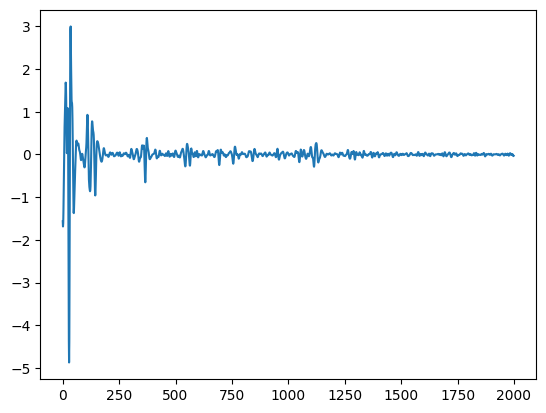

In [30]:
plt.plot(np.arange(train_loader.dataset[0][0][0].shape[1]), train_loader.dataset[380][0][0][0])
plt.show() 

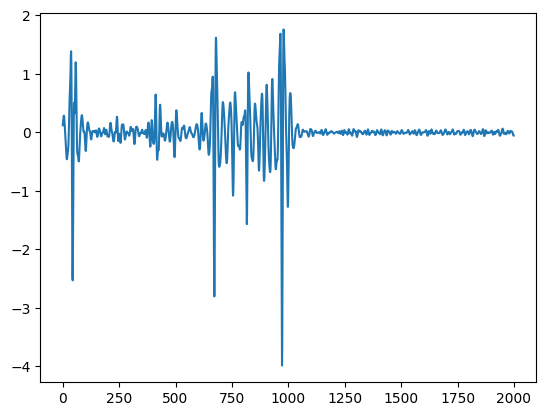

In [31]:
plt.plot(np.arange(val_loader.dataset[2][0][0].shape[1]), val_loader.dataset[0][0][0][0]) 
plt.show()

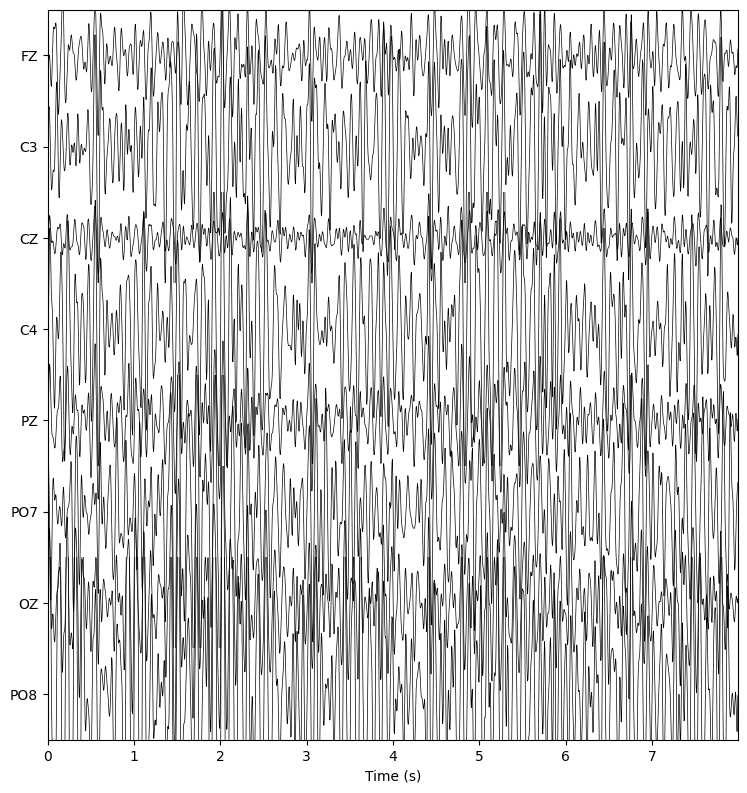

In [32]:
plot_signal(train_loader.dataset[1205][0][0],
            channel_list=["FZ", "C3", "CZ", "C4", "PZ", "PO7", "OZ", "PO8"],
            sampling_rate=250);

In [33]:
from datetime import datetime
import os
import shutil
import torch
from pytorch_lightning import seed_everything

from bci_aic3.paths import MI_RUNS_DIR, SSVEP_RUNS_DIR
from bci_aic3.train import train_model
from bci_aic3.util import get_model_class, save_model

torch.set_float32_matmul_precision("medium")

# Code necessary to create reproducible runs
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
seed_everything(42, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)


task_type = "MI"

config_path = None
save_path = None
if task_type.upper() == "MI":
    config_path = MI_CONFIG_PATH
    save_path = MI_RUNS_DIR
elif task_type.upper() == "SSVEP":
    config_path = SSVEP_CONFIG_PATH
    save_path = SSVEP_RUNS_DIR
else:
    raise (
        ValueError(f"Invalid task_type: {task_type}.\nValid task_type (MI) or (SSVEP)")
    )

model_config = load_model_config(config_path)

# model to use
model = get_model_class(model_config.name)
model_name = model.__name__

# Create a unique temporary directory first, using only the timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
temp_run_folder_name = f"{model_name}-{timestamp}-inprogress"
temp_run_save_dir = save_path / temp_run_folder_name

# Ensure directory and a subdirectory for checkpoints exist
checkpoints_subdir = temp_run_save_dir / "checkpoints"
os.makedirs(checkpoints_subdir, exist_ok=True)
print(f"Created temporary run directory: {temp_run_save_dir}")


Seed set to 42


Created temporary run directory: /home/Crim/AIC3/bci_aic3/run/MI/ATCNet-20250627_191141-inprogress


In [ ]:
# model = model(
#     num_electrodes=model_config.num_channels,
#     chunk_size=model_config.new_sequence_length,
#     num_classes=model_config.num_classes,
# )
from torcheeg.models import EEGNet, ATCNet

model = ATCNet(
    num_electrodes=model_config.num_channels,
    chunk_size=model_config.new_sequence_length,
    num_classes=model_config.num_classes,
    num_windows=5,
    tcn_kernel_size=16,
    F1=32,
    D=1,
    conv_pool_size=8,
    tcn_depth=3,
)

trainer, model = train_model(
    model=model,
    config_path=config_path,
    checkpoints_path=checkpoints_subdir,
    verbose=True,
)

f1_score = trainer.callback_metrics.get("val_f1")
if f1_score is None:
    # Fallback for early failure
    f1_score = 0.0

# Create the final directory name with f1 score
final_run_folder_name = f"{model_name}-f1-{f1_score:.4f}-{timestamp}"
final_save_dir = save_path / final_run_folder_name

# Rename the temporary directory to its final name
os.rename(temp_run_save_dir, final_save_dir)
print(f"Renamed run directory to: {final_save_dir}")

# Copy config file to new model directory
shutil.copy(config_path, final_save_dir / "config.yaml")
print(f"Saved config to {final_save_dir / 'config.yaml'}")


In [ ]:
save_model(model=model, save_path=final_save_dir / "weights.pt")
print(f"Saved config to {final_save_dir / 'weights.pt'}")

Saving model weights to /home/Crim/AIC3/bci_aic3/run/MI/ATCNet-f1-0.4198-20250627_030617/weights.pt...
Model weights saved successfully.
Saved config to /home/Crim/AIC3/bci_aic3/run/MI/ATCNet-f1-0.4198-20250627_030617/weights.pt


In [17]:
from pathlib import Path


def load_model(
    model_class: type[torch.nn.Module], model_path: Path, *args, **kwargs
) -> torch.nn.Module:
    """
    Loads a model's state dictionary from a file.

    This function first instantiates the model and then loads the saved
    state dictionary into it.

    Args:
        model_class (type[torch.nn.Module]): The class of the model to be loaded.
        model_path (Path): The path to the saved model's state_dict.
        *args: Variable length argument list for the model's constructor.
        **kwargs: Arbitrary keyword arguments for the model's constructor.

    Returns:
        torch.nn.Module: The loaded PyTorch model.
    """
    # Instantiate the model with its required arguments
    model = model_class(*args, **kwargs)

    # Load the state dictionary
    state_dict = torch.load(model_path)

    # Load the state dictionary into the model
    model.load_state_dict(state_dict)

    return model


In [74]:
from bci_aic3.train import BCILightningModule

In [ ]:
from pytorch_lightning import Trainer


model = BCILightningModule.load_from_checkpoint(
     "../run/MI/ATCNet-f1-0.5572-20250626_211717/checkpoints/atcnet-mi-best-f1-val_f1=0.5895-epoch=15.ckpt"
)

trainer = Trainer()

In [36]:
from bci_aic3.util import rec_cpu_count


max_num_workers = rec_cpu_count()

# Create data loaders
train_loader, val_loader = create_processed_data_loaders(
    processed_data_dir=PROCESSED_DATA_DIR,
    task_type=model_config.task_type,
    batch_size=training_config.batch_size,
    num_workers=max_num_workers,
)


In [55]:
mini_train_batch = next(iter(train_loader))

In [74]:
mini_train_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train, range(64)),
    batch_size=64,
    shuffle=True,
)

mini_val_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(val, range(50)),
    batch_size=64,
    shuffle=False,
)

In [ ]:
from bci_aic3.train import BCILightningModule, setup_callbacks
import pytorch_lightning as pl

model = EEGNet(
    num_electrodes=model_config.num_channels,
    chunk_size=model_config.new_sequence_length,
    num_classes=model_config.num_classes,
    # num_windows=5,
    # tcn_kernel_size=5,
    # F1=16,
    # D=1,
    # conv_pool_size=4,
    # tcn_depth=2,
)

# Create Lightning module
module = BCILightningModule(
    model=model,
    model_config=model_config,
    training_config=training_config,
)

# Setup callbacks
callbacks = setup_callbacks(
    model_config,
    patience=training_config.patience,
    verbose=True,
)

# Create trainer
trainer = pl.Trainer(
    max_epochs=training_config.epochs,
    callbacks=callbacks,
    accelerator="auto",  # Automatically uses GPU if available
    devices="auto",  # Uses all available devices
    deterministic=True,  # For reproducibility
    log_every_n_steps=10,
)

trainer.fit(module, mini_train_loader, mini_val_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | EEGNet             | 3.2 K  | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
4 | train_f1       | MulticlassF1Score  | 0      | train
5 | val_f1         | MulticlassF1Score  | 0      | train
--------------------------------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated mode

No checkpoints_path provided. Checkpointing is disabled.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [8, 1, 1, 64], expected input[1, 50, 8, 2250] to have 1 channels, but got 50 channels instead

In [76]:
score = torch.cat(trainer.predict(model, val_loader))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [81]:
import torch

pred_loader = DataLoader(val_loader.dataset, batch_size=len(val_loader.dataset))

In [82]:

reverse_label_mapping = read_json_to_dict(
    "../configs/label_mappings/reverse_label_mapping.json"
)

pred_indices = torch.argmax(score, dim=1).cpu().numpy()
val_labels = next(iter(pred_loader))[:][1]


In [84]:
from sklearn.metrics import f1_score

f1_score(pred_indices, val_labels)

0.4444444444444444

In [85]:
pred_labels = [reverse_label_mapping[str(idx)] for idx in pred_indices]
pred_labels

['Left',
 'Left',
 'Left',
 'Left',
 'Left',
 'Right',
 'Right',
 'Left',
 'Left',
 'Left',
 'Left',
 'Right',
 'Right',
 'Left',
 'Right',
 'Left',
 'Right',
 'Left',
 'Left',
 'Left',
 'Left',
 'Left',
 'Left',
 'Left',
 'Right',
 'Left',
 'Right',
 'Right',
 'Left',
 'Left',
 'Left',
 'Left',
 'Left',
 'Right',
 'Right',
 'Right',
 'Right',
 'Right',
 'Left',
 'Left',
 'Left',
 'Left',
 'Left',
 'Left',
 'Left',
 'Left',
 'Left',
 'Left',
 'Left',
 'Left']

In [ ]:
final_save_dir

PosixPath('/home/Crim/AIC3/bci_aic3/run/MI/ATCNet-f1-0.2870-20250626_231718')

In [ ]:
from sklearn.metrics import f1_score

model.eval()
with torch.no_grad():
    all_preds = []
    all_labels = []
    for data, labels in val_loader:
        outputs = model(data)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")
    print("Validation F1 score:", f1)

Validation F1 score: 0.41666666666666663


In [ ]:
score = trainer.predict(model, val_loader)

In [ ]:
import torch

reverse_label_mapping = read_json_to_dict(
    "../configs/label_mappings/reverse_label_mapping.json"
)
pred_indices = torch.argmax(score[0], dim=1).cpu().numpy()
pred_labels = [reverse_label_mapping[str(idx)] for idx in pred_indices]

In [ ]:
pred_labels